In [1]:
%load_ext autoreload
%autoreload 2
from spyglass.ripple.v1 import RippleTimesV1, RippleParameters
from spyglass.common import interval_list_intersect
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.lfp import LFPOutput

import numpy as np
from scipy.stats import ttest_rel
import statsmodels.stats as sm
from statsmodels.stats import proportion

import os
import matplotlib.pyplot as plt

from ms_stim_analysis.AnalysisTables.ms_opto_stim_protocol import OptoStimProtocol
from ms_stim_analysis.Analysis.utils import filter_opto_data, violin_scatter
from ms_stim_analysis.Style.style_guide import animal_style, interval_style
from ms_stim_analysis.AnalysisTables.decoding_tables import ClusterlessAheadBehindDistance, BadDecodes
from ms_stim_analysis.AnalysisTables.place_fields import DecodesToCoveredTrack

from ms_stim_analysis.AnalysisTables.decoding_tables import RippleClusterlessDecodeAnalysisSelection, RippleClusterlessDecodeAnalysis


from spyglass.position.v1 import TrodesPosV1
from spyglass.position.position_merge import PositionOutput
from spyglass.lfp.analysis.v1 import LFPBandV1

[2025-09-04 08:51:13,433][INFO]: DataJoint 0.14.6 connected to sambray@lmf-db.cin.ucsf.edu:3306


In [ ]:
# # Logging for database export. Not necessary for replication

# from spyglass.common.common_usage import Export, ExportSelection

# paper_key = {"paper_id": "ms_stim_analysis"}

# analysis_id = "ripple_decoding"
# ExportSelection().start_export(**paper_key, analysis_id=analysis_id)

[2025-09-04 08:49:25,143][WARNING]: Reconnecting to MySQL server.
[08:49:25][INFO] Spyglass: Starting {'export_id': 53}


# Look at ripple classification

In [2]:
from ms_stim_analysis.Style.style_guide import animal_style

track_coverage_filter = False

results = {}
for animal in animal_style.index:
    # animal = "Yoshi"
    data = RippleClusterlessDecodeAnalysis() & "nwb_file_name LIKE '%{}%'".format(
        animal
    )
    data = data - (BadDecodes() & {"bad_decodes": 1})
    k = data.fetch("KEY")  # [:3]
    data = data & k
    if not data:
        continue
    if track_coverage_filter:
        times_table = DecodesToCoveredTrack() & data.proj()
        times_keys = times_table.fetch("KEY")

        valid_intervals = []
        for key in times_keys:
            valid_intervals.extend((times_table & key).fetch_intervals())

        valid_intervals = np.array(valid_intervals)
        ind = np.argsort(valid_intervals[:, 0])
        valid_intervals = valid_intervals[ind]
    else:
        valid_intervals = None

    results[animal] = data.classify_ripple_decode(
        locality_threshold=20,
        valid_intervals=valid_intervals,
        valid_interval_fraction=0.8,
        thresh_percent=0.8,
    )
    # break

/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.2.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/home/sambray/mambaforge-pypy3/envs/ms_stim_analysis/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
ndx-franklab-novela - cached version: 0.1.0, loaded version: 0.2.1
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check t

Winnie 1181
Frodo 547
Totoro 580
Wallie 1068
Olive 394
Yoshi 1867
Bilbo 860


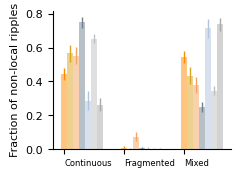

In [4]:
class_names = [
    "Continuous",
    "Fragmented",
    "Mixed",
]  # "Local",]#"Invalid"]

plt.rcParams.update({"font.size": 8})
fig = plt.figure(figsize=(2.3, 1.8))
ax = fig.gca()
for i, (animal, ripple_class) in enumerate(results.items()):
    width = 0.1
    # ripple_class = ripple_class[
    #     ~np.logical_or(ripple_class == "Local", ripple_class == "NAN")
    # ]
    exclude_ind = np.array([r in ["Local", "NAN", "Invalid"] for r in ripple_class])
    ripple_class = ripple_class[~exclude_ind]

    # class_names = np.unique(ripple_class)
    counts = [np.sum(ripple_class == class_name) for class_name in class_names]
    ci_list = sm.proportion.multinomial_proportions_confint(counts, alpha=0.05)
    print(animal, np.sum(counts))

    for j, class_name in enumerate(class_names):
        plt.bar(
            j + i * width,
            np.mean([ripple_class_i == class_name for ripple_class_i in ripple_class]),
            width,
            color=animal_style.loc[animal, "color"],
            label=animal if j == 0 else None,
            alpha=0.5,
        )
        plt.vlines(
            j + i * width,
            ci_list[j][0],
            ci_list[j][1],
            color=animal_style.loc[animal, "color"],
            lw=1,
        )
# plt.legend()  # loc = "lower left")
plt.xticks(range(len(class_names)), class_names, fontsize=6, ha="left")
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Fraction of non-local ripples")
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("../Figures/Fig_5/Fig_5c_ripple_classification.svg")

In [15]:
import statsmodels.stats as sm
from statsmodels.stats import proportion

counts = [np.sum(ripple_class == class_name) for class_name in class_names]
sm.proportion.multinomial_proportions_confint(counts, alpha=0.05)

array([[0.42829387, 0.5343583 ],
       [0.00085546, 0.0182728 ],
       [0.46169624, 0.56778889]])